### Emotion Analysis

In [1]:
!pip install emoji
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt_tab')
!pip install tf-keras
!pip install keras
!pip install contractions
!pip install tensorflow


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


#### Import Libraries

In [2]:
import pandas as pd
import re
import emoji
import time
import seaborn as sns
import contractions
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from nltk import pos_tag
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud
import gensim
from nltk.tokenize import sent_tokenize
from sklearn.svm import LinearSVC
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential  # Keep this for Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input  # Input here
# Removed: from sklearn.model_selection import train_test_split (already imported)
# Removed: from sklearn.metrics import classification_report (already imported)
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
# Removed: import tensorflow as tf (not needed explicitly for keras with tf 2.x)
# Removed: from keras import layers, models (redundant and may cause issues)

2025-01-17 11:41:03.037967: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/apple2015/Documents/MSc/SchoolStuff/NLP/Personal/Job Description Skill Analyzer/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load and Explore Data

In [3]:
def load_data(file_path):
    """Load the dataset from a file."""
    return pd.read_csv(file_path)

In [4]:
def explore_data(df, text_column='text', label_column='label'):
    """Perform an extensive exploration of the dataset to check data cleanliness."""

    print("\n--- Basic Information ---")
    print(f"Dataset Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
    print(f"Missing Values:\n{df.isnull().sum()}")
    print(f"Duplicate Rows: {df.duplicated().sum()}")

    print("\n--- Class Distribution ---")
    if label_column in df.columns:
        print(df[label_column].value_counts())

        # Plot class distribution
        plt.figure(figsize=(8, 4))
        df[label_column].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title("Class Distribution")
        plt.xlabel("Emotion Labels")
        plt.ylabel("Frequency")
        plt.show()
    else:
        print(f"No '{label_column}' column found!")

    print("\n--- Text Analysis ---")
    empty_texts = df[text_column].isnull().sum() + df[text_column].str.strip().eq('').sum()
    print(f"Empty or Blank Texts: {empty_texts}")

    # Checking text length distribution
    df['text_length'] = df[text_column].apply(lambda x: len(str(x).split()))
    print(f"Average Text Length: {df['text_length'].mean():.2f} words")
    print(f"Max Text Length: {df['text_length'].max()} words")
    print(f"Min Text Length: {df['text_length'].min()} words")

    # Checking for punctuation
    punctuations = df[text_column].apply(lambda x: len(re.findall(r'[^\w\s]', str(x))))
    print(f"Average Punctuation Count per Entry: {punctuations.mean():.2f}")

    # Check for emojis
    emojis_count = df[text_column].apply(lambda x: len(emoji.emoji_list(str(x))))
    print(f"Average Emoji Count per Entry: {emojis_count.mean():.2f}")

    # Checking for stop words
    stop_words = set(stopwords.words('english'))
    stop_word_counts = df[text_column].apply(lambda x: len([word for word in str(x).split() if word.lower() in stop_words]))
    print(f"Average Stop Words per Entry: {stop_word_counts.mean():.2f}")

    # Checking for numeric-only text (Fixed issue)
    numeric_texts = df[text_column].apply(lambda x: str(x).strip().isdigit()).sum()
    print(f"Entries with Only Numbers: {numeric_texts}")

    # Checking for excessive repeated characters
    repeated_char_counts = df[text_column].apply(lambda x: len(re.findall(r'(.)\1{2,}', str(x))))
    print(f"Average Excessive Repeated Characters per Entry: {repeated_char_counts.mean():.2f}")

    print("\n--- Recommendations ---")
    recommendations = []
    if empty_texts > 0:
        recommendations.append(f"Remove or handle {empty_texts} empty or blank entries.")
    if df.duplicated().sum() > 0:
        recommendations.append("Remove duplicate rows.")
    if emojis_count.sum() > 0:
        recommendations.append(f"Consider handling {emojis_count.sum()} emojis (e.g., replace with words or remove).")
    if punctuations.mean() > 0:
        recommendations.append("Remove or handle punctuation marks appropriately.")
    if numeric_texts > 0:
        recommendations.append(f"Consider removing {numeric_texts} entries containing only numbers.")
    if repeated_char_counts.mean() > 0:
        recommendations.append("Normalize excessive repeated characters (e.g., 'looooove' → 'love').")

    if recommendations:
        print("\n".join(recommendations))
    else:
        print("The dataset appears clean!")


In [5]:
#Drop empty rows from our data
def drop_empty_rows(df):
    """Drop rows with empty text values."""
    return df.dropna(subset=['text']).reset_index(drop=True)

#### Preprocess Text

In [6]:
def remove_emojis(text):
    """Remove emojis from text."""
    return emoji.replace_emoji(text, replace="")

def expand_contractions(text):
    """Expand contractions like don't -> do not"""
    return contractions.fix(text)

def remove_duplicates(df, column='text'):
    """Remove duplicate rows based on a specific column."""
    before = df.shape[0]  # Get the initial number of rows
    df = df.drop_duplicates(subset=[column]).reset_index(drop=True)  # Remove duplicates
    after = df.shape[0]  # Get the number of rows after removal

    return df

def remove_punctuation_and_symbols(text):
    """Remove punctuation, special characters, and standalone numbers (not in words)."""
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)  # Remove standalone numbers
    return text

def normalize_repeated_characters(text):
    """Normalize words with excessive character repetition (e.g., loooove -> love)."""
    return re.sub(r'(.)\1{2,}', r'\1', text)


def preprocess_text(text):
    """Clean and preprocess text."""
    text = remove_emojis(text)
    text = expand_contractions(text)
    text = remove_punctuation_and_symbols(text)
    text = normalize_repeated_characters(text)
    tokens = word_tokenize(text.lower())  # Tokenize first, then lowercase

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

def preprocess_text_stemming(text):
    """Clean and preprocess text using Stemming."""
    text = remove_emojis(text)
    text = expand_contractions(text)
    text = remove_punctuation_and_symbols(text)
    text = normalize_repeated_characters(text)
    tokens = word_tokenize(text.lower())  # Tokenize first, then lowercase

    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()

    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

def apply_preprocessing(df):
    """Apply preprocessing to the text column."""
    df['text'] = df['text'].apply(preprocess_text)
    return df

def apply_preprocessing_stemming(df):
    """Apply stemming-based preprocessing to the text column."""
    df['text_stemmed'] = df['text'].apply(preprocess_text_stemming)
    return df

### Measuring Performance and Effectiveness

In [7]:
# Function to measure execution time
def measure_time(func, df):
    start_time = time.time()
    df = func(df)
    end_time = time.time()
    execution_time = end_time - start_time
    return df, execution_time

#### Feature Engineering

In [60]:
def create_features_Tfidf(corpus):
    """Convert text into numerical representations."""
    vectorizer = TfidfVectorizer(max_features=5000)
    features = vectorizer.fit_transform(corpus)
    return features, vectorizer

def create_features_CountVectorizer(corpus):
    """Convert text into numerical representations."""
    vectorizer = CountVectorizer(max_features=5000)
    features = vectorizer.fit_transform(corpus)
    return features, vectorizer

# Create features using Word2Vec
def create_features_Word2Vec(corpus):
    """Convert text into numerical representations using Word2Vec."""
    tokenized_corpus = [doc.split() for doc in corpus]
    model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)
    # Calculate feature vectors as the mean of word vectors for each document
    features = np.array([
        np.mean([
            model.wv[word] for word in doc if word in model.wv
        ] or [np.zeros(100)], axis=0) for doc in tokenized_corpus
    ])
    return features, model


def create_features_FastText(corpus):
    """Convert text into numerical representations using FastText."""
    tokenized_corpus = [doc.split() for doc in corpus]
    model = FastText(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)

    features = np.array([
        np.mean([
            model.wv[word] for word in doc if word in model.wv
        ] or [np.zeros(100)], axis=0) for doc in tokenized_corpus
    ])
    return features, model

from transformers import BertTokenizer, BertModel
import torch

def create_features_BERT(corpus):
    """Convert text into numerical representations using BERT embeddings."""
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')

    # Convert corpus to a list of strings
    corpus = corpus.tolist()  # Ensure list format

    # Tokenize text
    inputs = tokenizer(corpus, padding=True, truncation=True, return_tensors="pt")

    # Extract features
    with torch.no_grad():
        outputs = model(**inputs)

    features = outputs.last_hidden_state[:, 0, :].numpy()  # CLS token representation
    return features, model



### Exploratory data analysis(EDA)

#### Model Training

##### Logistic Regression

In [9]:
def train_logistic_regression(X, y):
    """Train and evaluate a Logistic Regression model."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    print("\n--- Logistic Regression Evaluation ---")
    evaluate_model(model, X_test, y_test)
    return model

##### Random Forest

In [11]:
def train_random_forest(X, y):
    """Train and evaluate a Random Forest Classifier."""
    X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    print("\n--- Random Forest Evaluation ---")
    evaluate_model(model, X_test, y_test)
    return model

##### Support Vector Machine

In [12]:
def train_svm(X, y):
    """Train and evaluate a Support Vector Machine (SVM)."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # model = SVC(probability=False)

    """Train and evaluate a fast Support Vector Machine (SVM) using LinearSVC."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearSVC(dual=False)  # 🚀 Much faster than SVC(kernel='linear')
    model.fit(X_train, y_train)

    # model.fit(X_train, y_train)
    print("\n--- SVM Evaluation ---")
    evaluate_model(model, X_test, y_test)
    return model


#### Evaluate Model

In [13]:
#Evaluation Function

def evaluate_model(model, X_test, y_test):
    """Evaluate the performance of a trained model."""
    predictions = model.predict(X_test)
    print(classification_report(y_test, predictions))

#### Predict

In [14]:
def predict_emotion(model, text, vectorizer):
    """Predict the emotion of a single input text."""
    processed_text = preprocess_text(text)
    features = vectorizer.transform([processed_text])
    return model.predict(features)



--- Basic Information ---
Dataset Shape: (416809, 2)
Columns: ['text', 'label']
Missing Values:
text     0
label    0
dtype: int64
Duplicate Rows: 686

--- Class Distribution ---
label
1    141067
0    121187
3     57317
4     47712
2     34554
5     14972
Name: count, dtype: int64


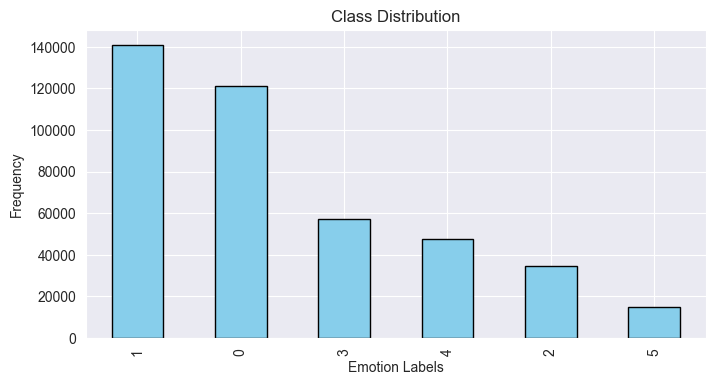


--- Text Analysis ---
Empty or Blank Texts: 0
Average Text Length: 19.21 words
Max Text Length: 178 words
Min Text Length: 1 words
Average Punctuation Count per Entry: 0.00
Average Emoji Count per Entry: 0.00
Average Stop Words per Entry: 9.85
Entries with Only Numbers: 0
Average Excessive Repeated Characters per Entry: 0.01

--- Recommendations ---
Remove duplicate rows.
Normalize excessive repeated characters (e.g., 'looooove' → 'love').


In [15]:
emotions_df = load_data('data/emotions.csv')
explore_data(emotions_df, text_column='text')


#### Class Distribution (Imbalance Visualization)

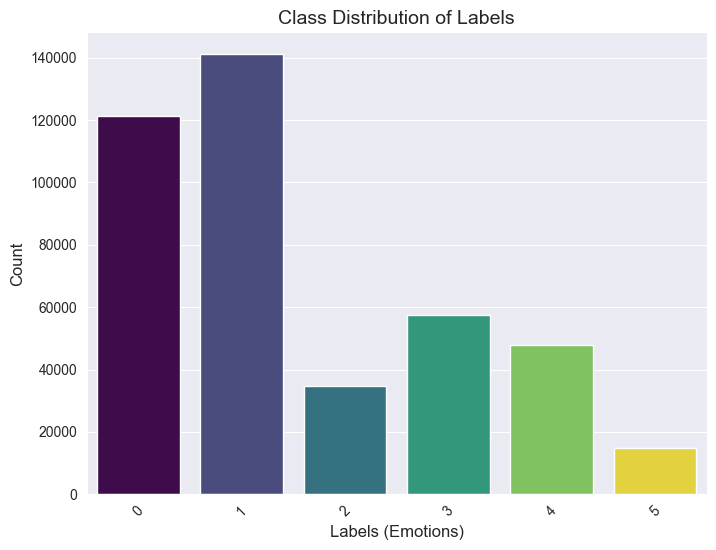

In [16]:
# Plot class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=emotions_df, hue='label', dodge=False, palette='viridis', legend=False)
plt.title("Class Distribution of Labels", fontsize=14)
plt.xlabel("Labels (Emotions)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()

#### Remove duplicated data

In [17]:
emotions_df = remove_duplicates(emotions_df, column='text')  # Remove duplicates first
emotions_df = emotions_df[emotions_df['text'].str.strip() != ""].reset_index(drop=True)


### Undersampling data

In [18]:
# Display the first few rows
emotions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393822 entries, 0 to 393821
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   text         393822 non-null  object
 1   label        393822 non-null  int64 
 2   text_length  393822 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 9.0+ MB


In [19]:
# Undersampling 14k rows from each category 0, 1, 2, 3, 4, 5
# Find the least frequent class count
min_count = emotions_df['label'].value_counts().min()  # Get smallest class size
print(f"Undersampling to {min_count} rows per class")


# Apply undersampling to match the smallest class
undersample_dataset = pd.concat([
    emotions_df[emotions_df['label'] == label].sample(n=min_count, random_state=42)
    for label in emotions_df['label'].unique()
])


# Display new class distribution
print("\nNew Class Distribution After Undersampling:")
print(undersample_dataset['label'].value_counts())


Undersampling to 12407 rows per class

New Class Distribution After Undersampling:
label
4    12407
0    12407
2    12407
1    12407
5    12407
3    12407
Name: count, dtype: int64



--- Basic Information ---
Dataset Shape: (74442, 3)
Columns: ['text', 'label', 'text_length']
Missing Values:
text           0
label          0
text_length    0
dtype: int64
Duplicate Rows: 0

--- Class Distribution ---
label
4    12407
0    12407
2    12407
1    12407
5    12407
3    12407
Name: count, dtype: int64


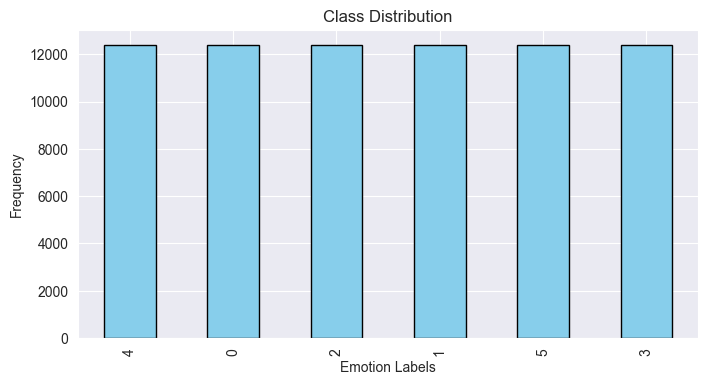


--- Text Analysis ---
Empty or Blank Texts: 0
Average Text Length: 19.50 words
Max Text Length: 101 words
Min Text Length: 1 words
Average Punctuation Count per Entry: 0.00
Average Emoji Count per Entry: 0.00
Average Stop Words per Entry: 10.03
Entries with Only Numbers: 0
Average Excessive Repeated Characters per Entry: 0.01

--- Recommendations ---
Normalize excessive repeated characters (e.g., 'looooove' → 'love').


In [20]:
explore_data(undersample_dataset, text_column='text')  # Adjust 'text' if your column name differs

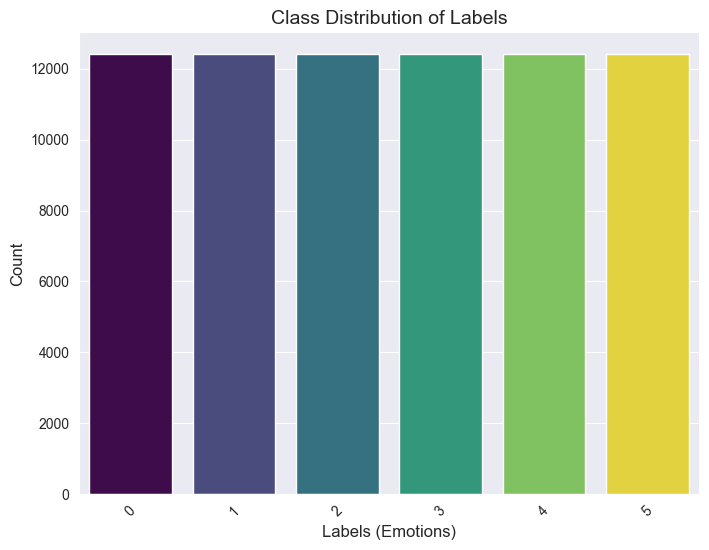

In [21]:
# Plot class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=undersample_dataset, hue='label', dodge=False, palette='viridis', legend=False)
plt.title("Class Distribution of Labels", fontsize=14)
plt.xlabel("Labels (Emotions)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()

We need to the checking here

In [24]:
# Measure Lemmatization Time
df, lemmatization_time = measure_time(apply_preprocessing, undersample_dataset)
print(f"Lemmatization Time: {lemmatization_time:.4f} seconds")

# Measure Stemming Time
df, stemming_time = measure_time(apply_preprocessing_stemming, undersample_dataset)
print(f"Stemming Time: {stemming_time:.4f} seconds")

Lemmatization Time: 45.1172 seconds
Stemming Time: 58.1028 seconds


In [22]:
emotions_df = apply_preprocessing(undersample_dataset)

In [23]:
emotions_df_stemming = apply_preprocessing_stemming(undersample_dataset)

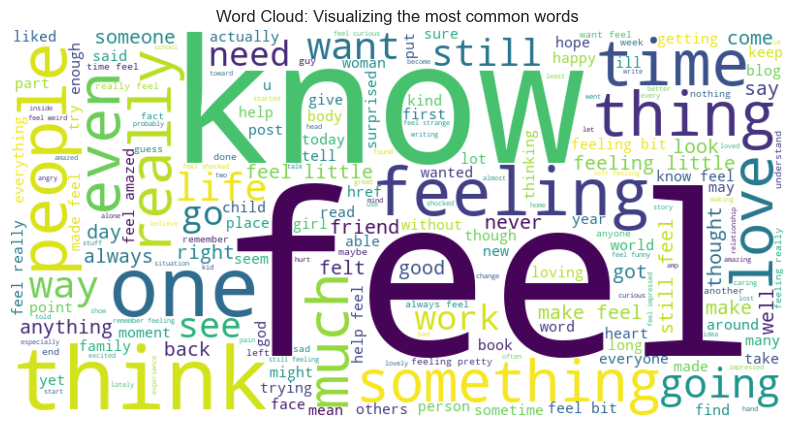

In [22]:
emotions_string = ' '.join(emotions_df['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(emotions_string)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud: Visualizing the most common words")

plt.show()

In [25]:
#create_features_Tfidf
XTfidf, vectorizer = create_features_Tfidf(emotions_df['text'])  # 'text' is the name of your text column
XWord2Vec, vectorizer = create_features_Word2Vec(emotions_df['text'])  # 'text' is the name of your text column
XCountVectorizer, vectorizer = create_features_Tfidf(emotions_df['text'])  # 'text' is the name of your text column

XTfidf_stem, vectorizer = create_features_Tfidf(emotions_df_stemming['text'])  # 'text' is the name of your text column
XWord2Vec_stem, vectorizer = create_features_Word2Vec(emotions_df_stemming['text'])  # 'text' is the name of your text column
XCountVectorizer_stem, vectorizer = create_features_Tfidf(emotions_df_stemming['text'])  # 'text' is the name of your text column
y = emotions_df['label']  # Assuming the label column is named 'label'


In [26]:
logistic_model = train_logistic_regression(XTfidf, y)


--- Logistic Regression Evaluation ---
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      2446
           1       0.93      0.92      0.92      2494
           2       0.94      0.96      0.95      2522
           3       0.94      0.94      0.94      2453
           4       0.93      0.90      0.91      2455
           5       0.93      0.97      0.95      2519

    accuracy                           0.93     14889
   macro avg       0.93      0.93      0.93     14889
weighted avg       0.93      0.93      0.93     14889



In [27]:
logistic_model = train_logistic_regression(XWord2Vec, y)


--- Logistic Regression Evaluation ---
              precision    recall  f1-score   support

           0       0.41      0.33      0.36      2446
           1       0.45      0.61      0.51      2494
           2       0.55      0.55      0.55      2522
           3       0.43      0.38      0.41      2453
           4       0.49      0.44      0.46      2455
           5       0.84      0.87      0.85      2519

    accuracy                           0.53     14889
   macro avg       0.53      0.53      0.52     14889
weighted avg       0.53      0.53      0.53     14889



In [28]:
logistic_model = train_logistic_regression(XCountVectorizer, y)


--- Logistic Regression Evaluation ---
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      2446
           1       0.93      0.92      0.92      2494
           2       0.94      0.96      0.95      2522
           3       0.94      0.94      0.94      2453
           4       0.93      0.90      0.91      2455
           5       0.93      0.97      0.95      2519

    accuracy                           0.93     14889
   macro avg       0.93      0.93      0.93     14889
weighted avg       0.93      0.93      0.93     14889



In [29]:
logistic_model = train_logistic_regression(XTfidf_stem, y)


--- Logistic Regression Evaluation ---
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      2446
           1       0.93      0.92      0.92      2494
           2       0.94      0.96      0.95      2522
           3       0.94      0.94      0.94      2453
           4       0.93      0.90      0.91      2455
           5       0.93      0.97      0.95      2519

    accuracy                           0.93     14889
   macro avg       0.93      0.93      0.93     14889
weighted avg       0.93      0.93      0.93     14889



In [30]:
logistic_model = train_logistic_regression(XWord2Vec_stem, y)


--- Logistic Regression Evaluation ---
              precision    recall  f1-score   support

           0       0.41      0.33      0.37      2446
           1       0.44      0.61      0.51      2494
           2       0.53      0.53      0.53      2522
           3       0.41      0.35      0.38      2453
           4       0.46      0.43      0.44      2455
           5       0.83      0.86      0.84      2519

    accuracy                           0.52     14889
   macro avg       0.52      0.52      0.51     14889
weighted avg       0.52      0.52      0.52     14889



In [31]:
logistic_model = train_logistic_regression(XCountVectorizer_stem, y)


--- Logistic Regression Evaluation ---
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      2446
           1       0.93      0.92      0.92      2494
           2       0.94      0.96      0.95      2522
           3       0.94      0.94      0.94      2453
           4       0.93      0.90      0.91      2455
           5       0.93      0.97      0.95      2519

    accuracy                           0.93     14889
   macro avg       0.93      0.93      0.93     14889
weighted avg       0.93      0.93      0.93     14889



In [32]:

print("\n--- Logistic Regression Evaluation ---")
evaluate_model(logistic_model, XTfidf, y)




--- Logistic Regression Evaluation ---
              precision    recall  f1-score   support

           0       0.96      0.94      0.95     12407
           1       0.96      0.92      0.94     12407
           2       0.94      0.98      0.96     12407
           3       0.96      0.96      0.96     12407
           4       0.95      0.92      0.94     12407
           5       0.93      0.98      0.96     12407

    accuracy                           0.95     74442
   macro avg       0.95      0.95      0.95     74442
weighted avg       0.95      0.95      0.95     74442



In [33]:
random_forest_model = train_random_forest(XTfidf, y) #XTfidf XWord2Vec XCountVectorizer


--- Random Forest Evaluation ---
              precision    recall  f1-score   support

           0       0.96      0.90      0.93      2446
           1       0.97      0.89      0.93      2494
           2       0.92      0.98      0.95      2522
           3       0.93      0.94      0.93      2453
           4       0.93      0.91      0.92      2455
           5       0.91      0.99      0.95      2519

    accuracy                           0.94     14889
   macro avg       0.94      0.94      0.94     14889
weighted avg       0.94      0.94      0.94     14889



In [27]:
svm_model = train_svm(XTfidf, y) #XWord2Vec XCountVectorizer


--- SVM Evaluation ---
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      2446
           1       0.93      0.92      0.92      2494
           2       0.94      0.96      0.95      2522
           3       0.94      0.94      0.94      2453
           4       0.93      0.90      0.91      2455
           5       0.93      0.97      0.95      2519

    accuracy                           0.94     14889
   macro avg       0.94      0.94      0.93     14889
weighted avg       0.94      0.94      0.94     14889



In [36]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(XWord2Vec, y, test_size=0.2, random_state=42)


In [39]:
# Reshape the data for LSTM: (samples, timesteps, features)
X_train_reshaped = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])


In [ ]:
print(np.mean(X_word2vec, axis=0))
print("---------------------------- ----------------------------")
print(np.std(X_word2vec, axis=0))

In [48]:
from tensorflow.keras.layers import Bidirectional


# Define the LSTM model
n_classes = len(np.unique(y))

lstm_model = Sequential()
# lstm_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Correct input shape
lstm_model.add(Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))  # Correct input shape

lstm_model.add(LSTM(256, activation='tanh', return_sequences=True))

lstm_model.add(LSTM(128, activation='tanh', return_sequences=True))  # First LSTM
lstm_model.add(Dropout(0.2))  # Reduced dropout for better learning

lstm_model.add(LSTM(64, activation='tanh'))  # Second LSTM
lstm_model.add(Dropout(0.2))  # Reduced dropout


lstm_model.add(Dense(50, activation='relu'))
lstm_model.add(Dense(n_classes, activation='softmax')) # Output layer for multi-class classification


lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 1, 256)         │       365,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 1, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           306 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 615,652 (2.35 MB)

 Trainable params: 615,652 (2.35 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Train the model
lstm_model.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, verbose=1)


Epoch 1/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 42s 22ms/step - accuracy: 0.4093 - loss: 1.4039
Epoch 2/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - accuracy: 0.4360 - loss: 1.3547
Epoch 3/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 33s 16ms/step - accuracy: 0.4467 - loss: 1.3251
Epoch 4/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - accuracy: 0.4590 - loss: 1.3092
Epoch 5/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - accuracy: 0.4730 - loss: 1.2865
Epoch 6/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.4777 - loss: 1.2694
Epoch 7/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.4848 - loss: 1.2549
Epoch 8/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.4896 - loss: 1.2454
Epoch 9/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - accuracy: 0.4957 - loss: 1.2313
Epoch 10/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.4981 - loss: 1.2215
Epoch 11/20
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.5074 - loss: 1.2052
Epoch 12

In [57]:
# Evaluate the model
loss, accuracy = lstm_model.evaluate(X_test_reshaped, y_test, verbose=1)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

466/466 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5419 - loss: 1.1318
Test Loss: 1.1276463270187378
Test Accuracy: 0.5429511666297913


## Trying BERT

In [ ]:
XBERT, vectorizer = create_features_BERT(emotions_df['text'])  # 'text' is the name of your text column

In [ ]:


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(XWord2Vec, y, test_size=0.2, random_state=42)



# Define the LSTM model
n_classes = len(np.unique(y))

lstm_model = Sequential()
# lstm_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # Correct input shape
lstm_model.add(Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))  # Correct input shape

lstm_model.add(LSTM(256, activation='tanh', return_sequences=True))

lstm_model.add(LSTM(128, activation='tanh', return_sequences=True))  # First LSTM
lstm_model.add(Dropout(0.2))  # Reduced dropout for better learning

lstm_model.add(LSTM(64, activation='tanh'))  # Second LSTM
lstm_model.add(Dropout(0.2))  # Reduced dropout


lstm_model.add(Dense(50, activation='relu'))
lstm_model.add(Dense(n_classes, activation='softmax')) # Output layer for multi-class classification


lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()


Epoch 1/10
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 43s 23ms/step - accuracy: 0.5416 - loss: 1.1282 - val_accuracy: 0.4920 - val_loss: 1.2448
Epoch 2/10
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.5380 - loss: 1.1436 - val_accuracy: 0.5358 - val_loss: 1.1410
Epoch 3/10
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 53s 28ms/step - accuracy: 0.5486 - loss: 1.1084 - val_accuracy: 0.5421 - val_loss: 1.1340
Epoch 4/10
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 44s 23ms/step - accuracy: 0.5544 - loss: 1.1004 - val_accuracy: 0.5376 - val_loss: 1.1367
Epoch 5/10
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.5538 - loss: 1.1003 - val_accuracy: 0.5186 - val_loss: 1.1937
Epoch 6/10
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - accuracy: 0.5608 - loss: 1.0896 - val_accuracy: 0.4875 - val_loss: 1.2809
Epoch 7/10
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.5513 - loss: 1.1092 - val_accuracy: 0.5435 - val_loss: 1.1310
Epoch 8/10
1862/1862 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.5562 -

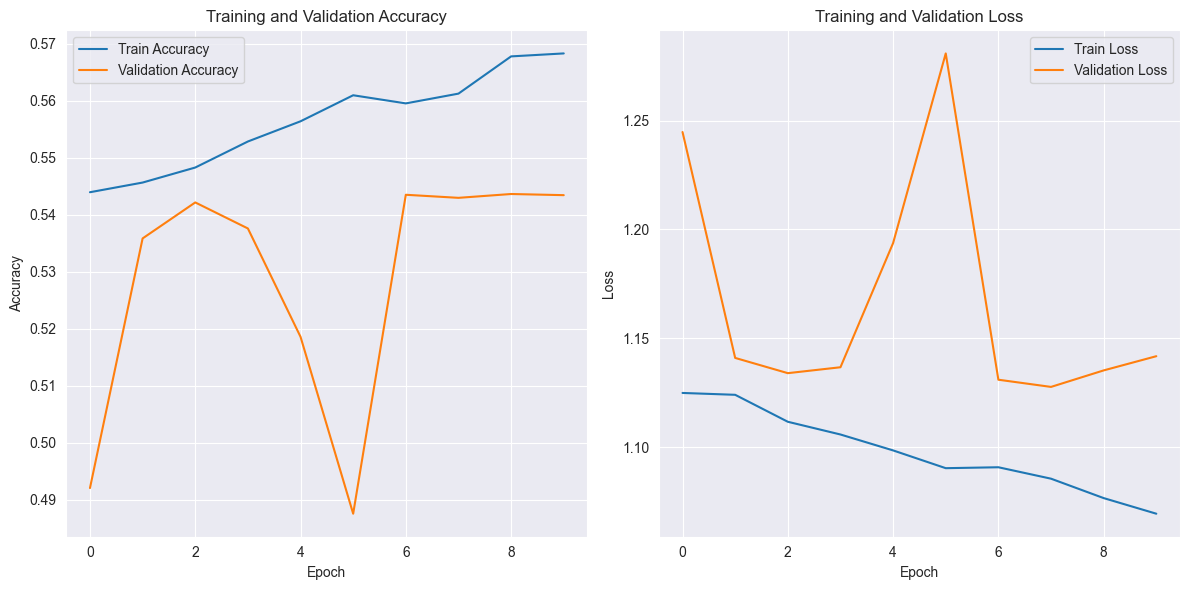

In [56]:
# Early stopping callback: Stop training if the validation loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Train the model with validation data and early stopping
history = lstm_model.fit(X_train_reshaped, y_train,
                         epochs=10, batch_size=32,
                         validation_data=(X_test_reshaped, y_test),
                         callbacks=[early_stopping], verbose=1)

# Plot training and validation loss/accuracy
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Build LSTM model
def build_lstm_model(vocab_size, embedding_dim, input_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=input_length),
        LSTM(128, return_sequences=True),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
lstm_model = build_lstm_model(vocab_size=20000, embedding_dim=100, input_length=100)
lstm_model.fit(X_train_reshaped, y_train, validation_split=0.2, epochs=5, batch_size=32)




In [ ]:
# Evaluate LSTM
lstm_predictions = lstm_model.predict(X_test_lstm)
lstm_pred_classes = np.argmax(lstm_predictions, axis=1)
print("\n--- LSTM Evaluation ---")
print(classification_report(y_test_lstm, lstm_pred_classes))


In [ ]:
# Prepare data for BERT
# def prepare_data_for_bert(df, text_column='text', label_column='label'):
#     tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#     inputs = tokenizer(list(df[text_column]), padding=True, truncation=True, return_tensors='pt', max_length=128)
#     labels = torch.tensor(df[label_column].values)
#     return inputs, labels

In [ ]:
# bert_inputs, bert_labels = prepare_data_for_bert(df)


In [ ]:
# # Train/Test split for BERT
# train_size = int(0.8 * len(bert_labels))
# train_inputs = {k: v[:train_size] for k, v in bert_inputs.items()}
# train_labels = bert_labels[:train_size]
# test_inputs = {k: v[train_size:] for k, v in bert_inputs.items()}
# test_labels = bert_labels[train_size:]


In [ ]:
# # Fine-tune BERT model
# bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)


In [ ]:
# training_args = TrainingArguments(
#     output_dir='./results',
#     num_train_epochs=3,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=16,
#     warmup_steps=500,
#     weight_decay=0.01,
#     logging_dir='./logs',
#     evaluation_strategy="epoch"
# )

In [ ]:
# trainer = Trainer(
#     model=bert_model,
#     args=training_args,
#     train_dataset=list(zip(train_inputs['input_ids'], train_labels)),
#     eval_dataset=list(zip(test_inputs['input_ids'], test_labels))
# )

In [ ]:
# trainer.train()

In [ ]:
# # Evaluate BERT
# bert_outputs = bert_model(**test_inputs)
# bert_pred_classes = torch.argmax(bert_outputs.logits, axis=1)
# print("\n--- BERT Evaluation ---")
# print(classification_report(test_labels.numpy(), bert_pred_classes.numpy()))

In [ ]:
sns.histplot(df['numerical_column'])


In [ ]:
sns.countplot(x='categorical_column', data=df)


In [ ]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')


In [ ]:
plt.show()


In [ ]:
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
sns.histplot(df['word_count'])


In [ ]:
from wordcloud import WordCloud
text = ' '.join(df['text'])
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
sns.countplot(x='label', data=df)
